In [ ]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import geopandas as gpd
from scipy.signal import argrelextrema
from sklearn.preprocessing import MinMaxScaler

In [2]:

pytrends = TrendReq(hl='fr-FR', tz=360)

# Analyse de l'intérêt pour le bio et les pesticides avec Google Trends

## Objectif de l'analyse
Nous nous intéressons à l'intérêt de la population pour les thèmes liés au bio et aux pesticides, en utilisant les données de Google Trends. 

## Sélection des mots-clés
Pour identifier les mots-clés les plus pertinents, nous avons préalablement réalisé une analyse des termes les plus fréquemment recherchés dans ces domaines. Cette démarche était nécessaire en raison de plusieurs difficultés :

- Les termes très spécifiques, comme **"agriculture biologique"**, sont particulièrement pertinents pour notre sujet, mais leur volume de recherche est faible.
- À l'inverse, des mots-clés plus généraux, comme **"bio"**, bénéficient d'un volume de recherche élevé, mais incluent des significations trop larges (e.g., biologie, cosmétiques bio), ce qui les rend peu spécifiques.

## Liste initiale des mots-clés analysés
### Mots-clés pour le bio
- agriculture bio
- terrain bio
- agriculture biologique
- manger bio
- consommer bio
- consommation bio
- bio

### Mots-clés pour les pesticides
- pesticide
- herbicide
- nappes phréatiques polluées
- pollution de l'eau
- qualité de l'eau

## Mots-clés retenus
Suite à cette analyse, nous avons sélectionné les mots-clés suivants, à la fois pertinents pour notre sujet et suffisamment recherchés :

### Pour le bio :
- **agriculture bio** (intérêt pour la production)
- **manger bio** (intérêt pour la consommation)

### Pour les pesticides :
- **pesticides** (intérêt pour la production)
- **qualité de l'eau** (intérêt pour les impacts sur la consommation)

## Approche
Cette sélection nous permet de traiter deux axes majeurs :
1. L'intérêt pour la **production** à travers les termes : *"agriculture bio"* et *"pesticides"*.
2. L'intérêt pour la **consommation** à travers les termes : *"manger bio"* et *"qualité de l'eau"*.

Ces mots-clés seront analysés afin d'évaluer la perception et les préoccupations de la population concernant ces thématiques.


In [3]:
keywords_bio = [
    "agriculture bio", 
    "manger bio", 
]


In [4]:
keywords_pesticides = [
    "pesticides",  
    "qualité de l'eau", 
]


# Analyse de l'intérêt par région

## Objectif
Nous nous intéressons en premier lieu à l'intérêt pour les thématiques du bio et des pesticides selon les différentes régions de France. Cette analyse géographique permet d'identifier les disparités régionales et d'explorer les dynamiques locales concernant ces préoccupations.

## Visualisation
Pour représenter ces données, nous avons créé une carte colorimétrique. Celle-ci illustre l'intérêt relatif pour les mots-clés retenus dans chaque région, en utilisant une échelle de couleurs où des teintes plus intenses indiquent un intérêt plus marqué.

## Données régionales sur Google Trends
Google Trends fournit des données géographiques basées sur les **anciennes régions françaises** (avant la réforme territoriale de 2016). Par conséquent, il a été nécessaire de transformer ces données pour les adapter à la nouvelle organisation régionale actuelle.

## Fonctionnement de Google Trends
Les valeurs fournies par Google Trends sont déjà **pondérées** par la population et d'autres facteurs. En effet, Google Trends analyse un échantillon des recherches effectuées sur Google et présente les données sur une échelle de 0 à 100, où chaque point est calculé en fonction du point le plus élevé, soit 100. Les données sont normalisées pour refléter la popularité relative d'un terme de recherche par rapport au nombre total de recherches effectuées sur Google pendant une période donnée. 

## Résultat attendu
La carte colorimétrique obtenue fournit une vue d'ensemble de l'intérêt relatif pour le bio et les pesticides à l'échelle régionale. Cela constitue une base pour explorer plus en détail les facteurs locaux influençant ces préoccupations, tels que les pratiques agricoles, la sensibilisation écologique ou les problématiques environnementales spécifiques.


In [5]:
# Correspondance entre anciennes et nouvelles régions
mapping = {
    'Alsace': 'Grand Est',
    'Aquitaine': 'Nouvelle-Aquitaine',
    'Auvergne': 'Auvergne-Rhône-Alpes',
    'Basse-Normandie': 'Normandie',
    'Bourgogne': 'Bourgogne-Franche-Comté',
    'Bretagne': 'Bretagne',
    'Centre-Val de Loire': 'Centre-Val de Loire',
    'Champagne-Ardenne': 'Grand Est',
    'Corse': 'Corse',
    'Franche-Comté': 'Bourgogne-Franche-Comté',
    'Haute-Normandie': 'Normandie',
    'Languedoc-Roussillon': 'Occitanie',
    'Limousin': 'Nouvelle-Aquitaine',
    'Lorraine': 'Grand Est',
    'Midi-Pyrénées': 'Occitanie',
    'Nord-Pas-de-Calais': 'Hauts-de-France',
    'Pays de la Loire': 'Pays de la Loire',
    'Picardie': 'Hauts-de-France',
    'Poitou-Charentes': 'Nouvelle-Aquitaine',
    "Provence-Alpes-Côte d'Azur": "Provence-Alpes-Côte d'Azur",
    'Rhône-Alpes': 'Auvergne-Rhône-Alpes',
    'Île-de-France': 'Île-de-France'
}

In [6]:

# Charger les données géographiques des régions françaises depuis GeoJSON
geojson_url = "https://france-geojson.gregoiredavid.fr/repo/regions.geojson"
regions_map = gpd.read_file(geojson_url)

## Récupération des données pour le bio

In [7]:
# Dictionnaire pour stocker les résultats
results_by_keyword = {}

for keyword in keywords_bio:
    try:
        # Construire la requête pour le mot-clé
        pytrends.build_payload([keyword], geo='FR', timeframe='2022-01-01 2022-12-31')
        
        # Pause pour éviter les limitations de Google Trends
        time.sleep(120)
        
        # Obtenir les données par région
        data = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True)
        
        # Transformer les données en dictionnaire
        regional_data = data[keyword].to_dict()  # 'keyword' est le nom de la colonne des valeurs
        
        # Ajouter au dictionnaire global
        results_by_keyword[keyword] = regional_data
        
        print(f"Résultats pour '{keyword}' récupérés avec succès.")
    
    except Exception as e:
        print(f"Erreur avec le mot-clé '{keyword}': {e}")

# Afficher le dictionnaire des résultats
print(results_by_keyword)

Résultats pour 'agriculture bio' récupérés avec succès.
Résultats pour 'manger bio' récupérés avec succès.
{'agriculture bio': {'Alsace': 37, 'Aquitaine': 54, 'Auvergne': 52, 'Basse-Normandie': 40, 'Bourgogne': 66, 'Bretagne': 74, 'Centre-Val de Loire': 47, 'Champagne-Ardenne': 48, 'Corse': 96, 'Franche-Comté': 57, 'Haute-Normandie': 39, 'Languedoc-Roussillon': 64, 'Limousin': 100, 'Lorraine': 42, 'Midi-Pyrénées': 84, 'Nord-Pas-de-Calais': 34, 'Pays de la Loire': 69, 'Picardie': 43, 'Poitou-Charentes': 62, "Provence-Alpes-Côte d'Azur": 40, 'Rhône-Alpes': 47, 'Île-de-France': 41}, 'manger bio': {'Alsace': 72, 'Aquitaine': 92, 'Auvergne': 66, 'Basse-Normandie': 70, 'Bourgogne': 59, 'Bretagne': 90, 'Centre-Val de Loire': 64, 'Champagne-Ardenne': 42, 'Corse': 0, 'Franche-Comté': 64, 'Haute-Normandie': 51, 'Languedoc-Roussillon': 58, 'Limousin': 0, 'Lorraine': 42, 'Midi-Pyrénées': 69, 'Nord-Pas-de-Calais': 55, 'Pays de la Loire': 100, 'Picardie': 34, 'Poitou-Charentes': 53, "Provence-Alpes-

In [8]:
# Convertir les résultats en données correspondantes aux régions mappées
mapped_regions_data_agriculture = [(mapping.get(region, region), score) for region, score in results_by_keyword['agriculture bio'].items()]
mapped_regions_data_manger = [(mapping.get(region, region), score) for region, score in results_by_keyword['manger bio'].items()]

# Ajouter les scores aux données géographiques pour chaque mot-clé
scores_dict_agriculture = dict(mapped_regions_data_agriculture)
scores_dict_manger = dict(mapped_regions_data_manger)

regions_map["score_agriculture"] = regions_map["nom"].map(scores_dict_agriculture)
regions_map["score_manger"] = regions_map["nom"].map(scores_dict_manger)

# Filtrer les régions sans score (Guadeloupe, Martinique, Guyane, La Réunion, Mayotte)
regions_map_filtered_agriculture = regions_map[regions_map["score_agriculture"].notna()]
regions_map_filtered_manger = regions_map[regions_map["score_manger"].notna()]

## Récupération des données pour les pesticides 

In [9]:
# Dictionnaire pour stocker les résultats par mot-clé
results_by_keyword_p = {}

for keyword in keywords_pesticides:
    try:
        # Construire la requête pour chaque mot-clé
        pytrends.build_payload([keyword], geo='FR', timeframe='2022-01-01 2022-12-31')
        
        # Pause pour éviter les limitations de Google Trends
        time.sleep(120)
        
        # Obtenir les données par région
        data = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True)
        
        # Transformer les données en dictionnaire pour chaque mot-clé
        regional_data = data[keyword].to_dict()  # Le mot-clé est le nom de la colonne des valeurs
        
        # Ajouter les résultats au dictionnaire global
        results_by_keyword_p[keyword] = regional_data
        
        print(f"Résultats pour '{keyword}' récupérés avec succès.")
    
    except Exception as e:
        print(f"Erreur avec le mot-clé '{keyword}': {e}")

# Afficher le dictionnaire des résultats
print(results_by_keyword_p)

Résultats pour 'pesticides' récupérés avec succès.
Résultats pour 'qualité de l'eau' récupérés avec succès.
{'pesticides': {'Alsace': 74, 'Aquitaine': 82, 'Auvergne': 70, 'Basse-Normandie': 72, 'Bourgogne': 71, 'Bretagne': 100, 'Centre-Val de Loire': 70, 'Champagne-Ardenne': 72, 'Corse': 61, 'Franche-Comté': 65, 'Haute-Normandie': 61, 'Languedoc-Roussillon': 90, 'Limousin': 78, 'Lorraine': 72, 'Midi-Pyrénées': 86, 'Nord-Pas-de-Calais': 68, 'Pays de la Loire': 79, 'Picardie': 77, 'Poitou-Charentes': 97, "Provence-Alpes-Côte d'Azur": 68, 'Rhône-Alpes': 70, 'Île-de-France': 74}, "qualité de l'eau": {'Alsace': 83, 'Aquitaine': 59, 'Auvergne': 73, 'Basse-Normandie': 61, 'Bourgogne': 66, 'Bretagne': 74, 'Centre-Val de Loire': 83, 'Champagne-Ardenne': 57, 'Corse': 81, 'Franche-Comté': 73, 'Haute-Normandie': 54, 'Languedoc-Roussillon': 85, 'Limousin': 100, 'Lorraine': 55, 'Midi-Pyrénées': 62, 'Nord-Pas-de-Calais': 64, 'Pays de la Loire': 70, 'Picardie': 65, 'Poitou-Charentes': 77, "Provence-Al

In [10]:
# Convertir les résultats en données correspondantes aux régions mappées
mapped_regions_data_pesticides = [(mapping.get(region, region), score) for region, score in results_by_keyword_p['pesticides'].items()]
mapped_regions_data_qualite_eau = [(mapping.get(region, region), score) for region, score in results_by_keyword_p['qualité de l\'eau'].items()]

# Ajouter les scores aux données géographiques pour chaque mot-clé
scores_dict_pesticides = dict(mapped_regions_data_pesticides)
scores_dict_qualite_eau = dict(mapped_regions_data_qualite_eau)

regions_map["score_pesticides"] = regions_map["nom"].map(scores_dict_pesticides)
regions_map["score_qualite_eau"] = regions_map["nom"].map(scores_dict_qualite_eau)

# Filtrer les régions sans score (par exemple, Guadeloupe, Martinique, Guyane, La Réunion, Mayotte)
regions_map_filtered_pesticides = regions_map[regions_map["score_pesticides"].notna()]
regions_map_filtered_qualite_eau = regions_map[regions_map["score_qualite_eau"].notna()]

## Affichage des cartes

<Figure size 1000x1000 with 0 Axes>

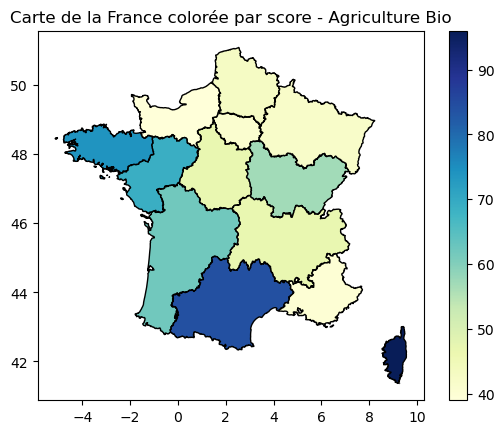

<Figure size 1000x1000 with 0 Axes>

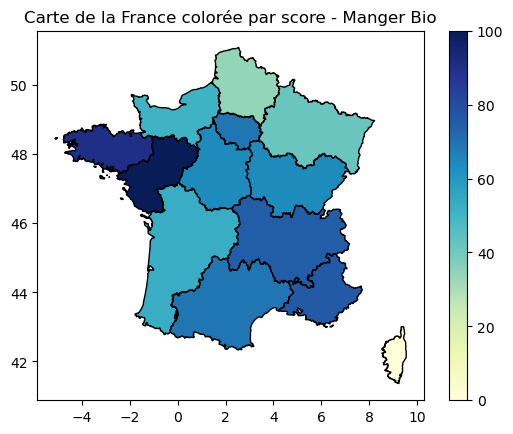

In [11]:
# Ajuster l'échelle des couleurs en fonction des valeurs de score pour chaque carte
min_score_agriculture = regions_map_filtered_agriculture["score_agriculture"].min()
max_score_agriculture = regions_map_filtered_agriculture["score_agriculture"].max()

min_score_manger = regions_map_filtered_manger["score_manger"].min()
max_score_manger = regions_map_filtered_manger["score_manger"].max()

# Visualisation de la carte pour "agriculture bio"
plt.figure(figsize=(10, 10))
regions_map_filtered_agriculture.plot(
    column="score_agriculture", 
    cmap="YlGnBu", 
    legend=True, 
    edgecolor="black", 
    missing_kwds={"color": "lightgrey"},
    vmin=min_score_agriculture,  # Valeur minimale pour l'échelle des couleurs
    vmax=max_score_agriculture   # Valeur maximale pour l'échelle des couleurs
)
plt.title("Carte de la France colorée par score - Agriculture Bio")
plt.show()

# Visualisation de la carte pour "manger bio"
plt.figure(figsize=(10, 10))
regions_map_filtered_manger.plot(
    column="score_manger", 
    cmap="YlGnBu", 
    legend=True, 
    edgecolor="black", 
    missing_kwds={"color": "lightgrey"},
    vmin=min_score_manger,  # Valeur minimale pour l'échelle des couleurs
    vmax=max_score_manger   # Valeur maximale pour l'échelle des couleurs
)
plt.title("Carte de la France colorée par score - Manger Bio")
plt.show()


<Figure size 1000x1000 with 0 Axes>

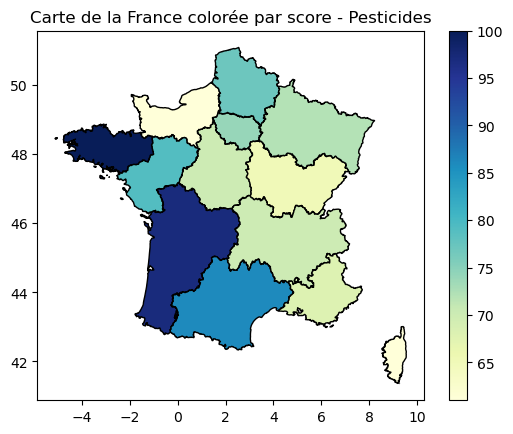

<Figure size 1000x1000 with 0 Axes>

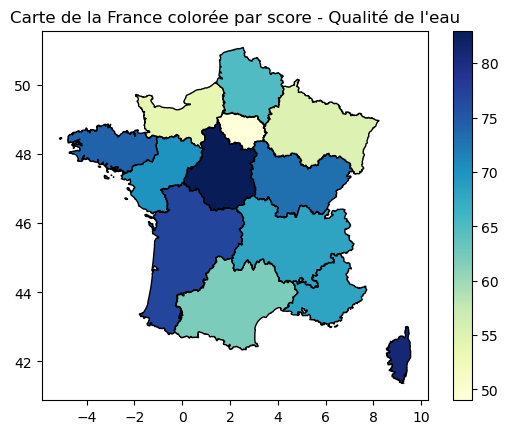

In [12]:
# Ajuster l'échelle des couleurs en fonction des valeurs de score pour chaque carte
min_score_pesticides = regions_map_filtered_pesticides["score_pesticides"].min()
max_score_pesticides = regions_map_filtered_pesticides["score_pesticides"].max()

min_score_qualite_eau = regions_map_filtered_qualite_eau["score_qualite_eau"].min()
max_score_qualite_eau = regions_map_filtered_qualite_eau["score_qualite_eau"].max()

# Visualisation de la carte pour "pesticides"
plt.figure(figsize=(10, 10))
regions_map_filtered_pesticides.plot(
    column="score_pesticides", 
    cmap="YlGnBu", 
    legend=True, 
    edgecolor="black", 
    missing_kwds={"color": "lightgrey"},
    vmin=min_score_pesticides,  # Valeur minimale pour l'échelle des couleurs
    vmax=max_score_pesticides   # Valeur maximale pour l'échelle des couleurs
)
plt.title("Carte de la France colorée par score - Pesticides")
plt.show()

# Visualisation de la carte pour "qualité de l'eau"
plt.figure(figsize=(10, 10))
regions_map_filtered_qualite_eau.plot(
    column="score_qualite_eau", 
    cmap="YlGnBu", 
    legend=True, 
    edgecolor="black", 
    missing_kwds={"color": "lightgrey"},
    vmin=min_score_qualite_eau,  # Valeur minimale pour l'échelle des couleurs
    vmax=max_score_qualite_eau   # Valeur maximale pour l'échelle des couleurs
)
plt.title("Carte de la France colorée par score - Qualité de l'eau")
plt.show()


# Analyse des cartes "Qualité de l'eau" et "Pesticides"

## Pesticides
Les recherches sur "Pesticides" sont plus marquées dans certaines régions agricoles comme le sud-ouest ou la Bretagne. Cela reflète un intérêt spécifique aux zones où les pesticides sont davantage utilisés ou où leurs impacts environnementaux, comme la pollution des nappes phréatiques, sont plus visibles. Ce phénomène est lié à une sensibilité accrue dans ces régions aux débats sur l'utilisation des pesticides et leurs effets sur l'environnement.

## Qualité de l'eau
La carte montre une répartition relativement homogène des recherches liées à la "Qualité de l'eau", bien qu'on observe une légère concentration dans certaines régions. Cet intérêt généralisé s'explique par le fait que la qualité de l'eau est une préoccupation partagée par l'ensemble de la population. En effet, l'eau potable est une ressource essentielle pour tous, indépendamment de l'activité agricole.


# Analyse des cartes "Manger Bio" et "Agriculture Bio"

## Manger Bio
La carte montre une répartition homogène des recherches sur "Manger Bio", indiquant un intérêt universel pour la consommation de produits bio. Cela s'explique par le fait que tout le monde, qu'il soit citadin ou rural, se sent concerné par l'alimentation bio.

## Agriculture Bio
En revanche, les recherches sur "Agriculture Bio" sont concentrées dans les régions agricoles, comme le sud-ouest ou la Bretagne. Cela reflète un intérêt plus technique, lié à la production, et spécifique aux zones où l'activité agricole est importante.

# Analyse de l'évolution des recherches dans le temps

## Objectif
Nous allons maintenant analyser l'évolution des recherches sur ces mots-clés au fil du temps. Cette étape nous permettra de mieux comprendre les dynamiques temporelles des recherches et leur relation entre elles.

## Méthodologie
1. **Analyse individuelle** :  
   Dans un premier temps, nous examinerons l'évolution de la popularité de chaque mot-clé indépendamment (*"manger bio"*, *"agriculture bio"*, *"pesticides"*, *"qualité de l'eau"*) afin de comparer les périodes de maximum de popularité. L'objectif est de voir si ces pics correspondent ou s'ils sont décalés dans le temps.

2. **Analyse comparative** :  
   Ensuite, nous analyserons l'évolution des recherches en comparant directement les mots-clés entre eux. Pour cela, nous avons utilisé Google Trends en entrant deux mots-clés simultanément, ce qui change la manière dont les valeurs sont calculées. Contrairement à une analyse séparée, où les scores sont normalisés par rapport au maximum de chaque mot-clé, une analyse conjointe normalise les résultats des deux mots-clés l'un par rapport à l'autre. Cela permet d'observer leur popularité relative sur la même échelle.


In [13]:
# Définir la période de temps (2000-2024)
start_date = '2000-01-01'
end_date = '2024-12-31'

## Récupération des données

In [14]:
# Créer un dictionnaire pour stocker les résultats
trend_data = {}

# Récupérer les données de Google Trends pour chaque mot-clé
for keyword in keywords_bio:
    try:
        # Construire la requête pour le mot-clé
        pytrends.build_payload([keyword], geo='FR', timeframe=f'{start_date} {end_date}')
        
        # Récupérer les données d'intérêt au fil du temps
        data = pytrends.interest_over_time()
        
        # Ajouter les résultats dans le dictionnaire
        trend_data[keyword] = data[keyword]
        
        # Pause pour éviter les limitations de Google Trends
        time.sleep(60)
        
        print(f"Les données pour '{keyword}' ont été récupérées avec succès.")
    except Exception as e:
        print(f"Erreur pour le mot-clé '{keyword}': {e}")

/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Les données pour 'agriculture bio' ont été récupérées avec succès.


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Les données pour 'manger bio' ont été récupérées avec succès.


In [15]:
# Créer un dictionnaire pour stocker les résultats
trend_data_p = {}

# Récupérer les données de Google Trends pour chaque mot-clé
for keyword in keywords_pesticides:
    try:
        # Construire la requête pour le mot-clé
        pytrends.build_payload([keyword], geo='FR', timeframe=f'{start_date} {end_date}')
        
        # Récupérer les données d'intérêt au fil du temps
        data = pytrends.interest_over_time()
        
        # Ajouter les résultats dans le dictionnaire
        trend_data_p[keyword] = data[keyword]
        
        # Pause pour éviter les limitations de Google Trends
        time.sleep(60)
        
        print(f"Les données pour '{keyword}' ont été récupérées avec succès.")
    except Exception as e:
        print(f"Erreur pour le mot-clé '{keyword}': {e}")

/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Les données pour 'pesticides' ont été récupérées avec succès.


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Les données pour 'qualité de l'eau' ont été récupérées avec succès.


## Affichage des graphiques pour l'analyse individuelle

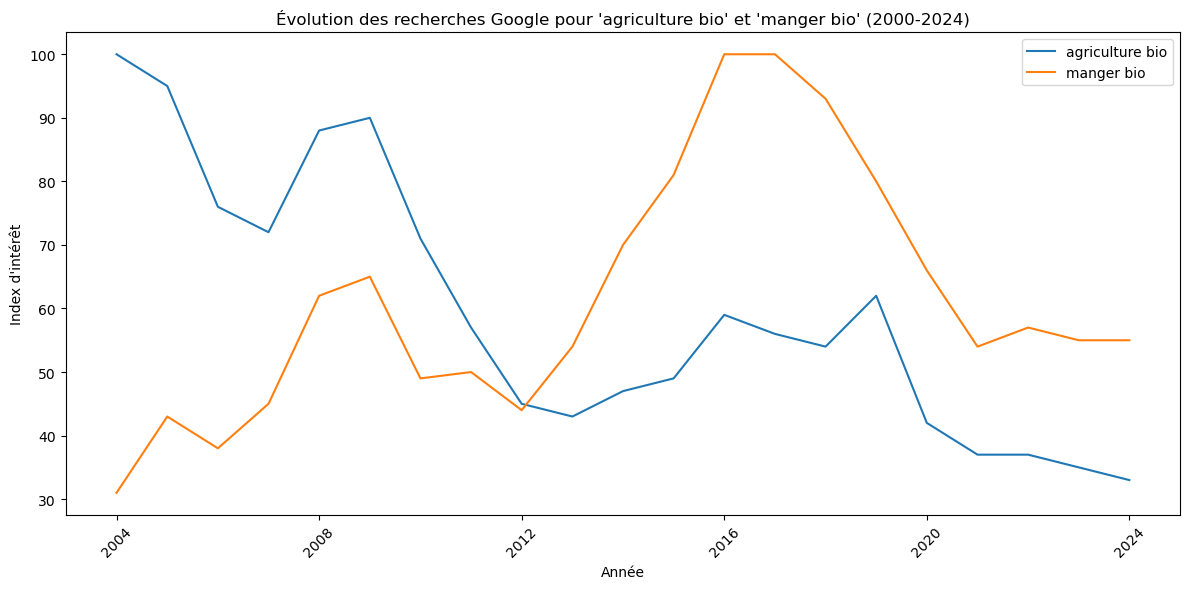

In [16]:
# Créer le graphique
plt.figure(figsize=(12, 6))

# Tracer les courbes pour chaque mot-clé
for keyword in keywords_bio:
    plt.plot(trend_data[keyword].index, trend_data[keyword], label=keyword)

# Ajouter les labels et la légende
plt.title("Évolution des recherches Google pour 'agriculture bio' et 'manger bio' (2000-2024)")
plt.xlabel("Année")
plt.ylabel("Index d'intérêt")
plt.legend()

# Afficher le graphique
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Créer le graphique
plt.figure(figsize=(12, 6))

# Tracer les courbes pour chaque mot-clé
for keyword in keywords_pesticides:
    plt.plot(trend_data_p[keyword].index, trend_data[keyword], label=keyword)

# Ajouter les labels et la légende
plt.title("Évolution des recherches Google pour 'pesticides' et 'qualité de l'eau' (2000-2024)")
plt.xlabel("Année")
plt.ylabel("Index d'intérêt")
plt.legend()

# Afficher le graphique
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyError: 'pesticides'

<Figure size 1200x600 with 0 Axes>

## Affichage des graphiques comparatifs

/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


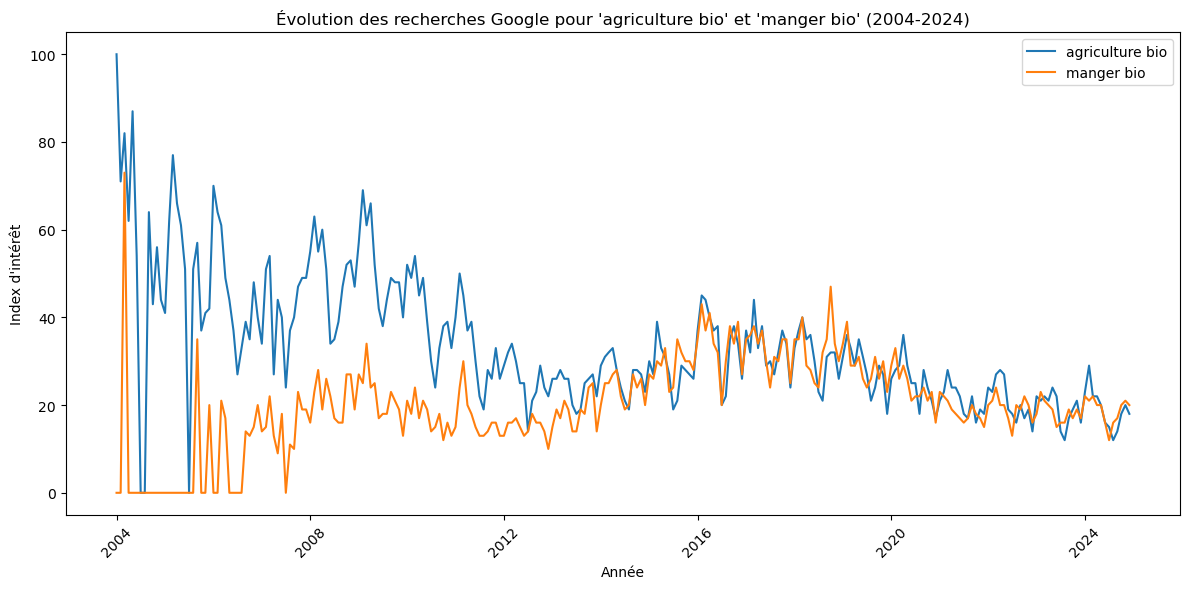

In [ ]:
# Construire la requête pour tous les mots-clés en même temps
try:
    pytrends.build_payload(keywords_bio, geo='FR', timeframe=f'{start_date} {end_date}')
    
    # Récupérer les données d'intérêt au fil du temps
    data = pytrends.interest_over_time()

    # Vérifier que les données contiennent des résultats valides
    if data.empty:
        print("Aucune donnée disponible pour les mots-clés fournis.")
    else:
        # Créer le graphique
        plt.figure(figsize=(12, 6))

        # Tracer les courbes pour chaque mot-clé
        for keyword in keywords_bio:
            plt.plot(data.index, data[keyword], label=keyword)

        # Ajouter les labels et la légende
        plt.title("Évolution des recherches Google pour 'agriculture bio' et 'manger bio' (2004-2024)")
        plt.xlabel("Année")
        plt.ylabel("Index d'intérêt")
        plt.legend()

        # Afficher le graphique
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Erreur lors de la récupération des données : {e}")


/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


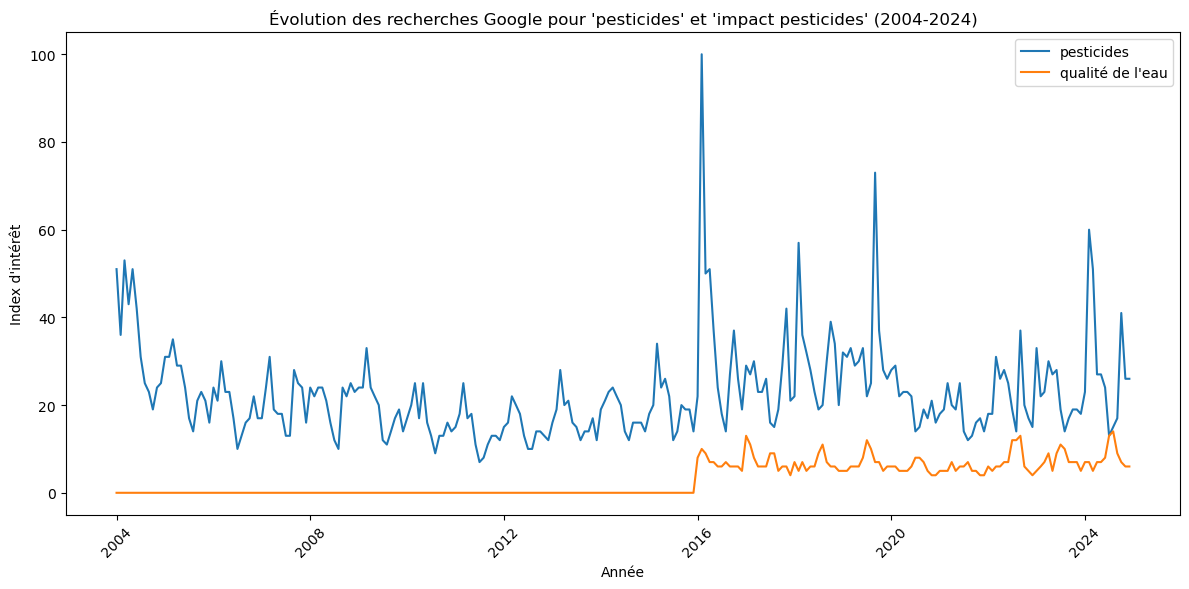

In [ ]:
# Construire la requête pour tous les mots-clés en même temps
try:
    pytrends.build_payload(keywords_pesticides, geo='FR', timeframe=f'{start_date} {end_date}')
    
    # Récupérer les données d'intérêt au fil du temps
    data = pytrends.interest_over_time()

    # Vérifier que les données contiennent des résultats valides
    if data.empty:
        print("Aucune donnée disponible pour les mots-clés fournis.")
    else:
        # Créer le graphique
        plt.figure(figsize=(12, 6))

        # Tracer les courbes pour chaque mot-clé
        for keyword in keywords_pesticides:
            plt.plot(data.index, data[keyword], label=keyword)

        # Ajouter les labels et la légende
        plt.title("Évolution des recherches Google pour 'pesticides' et 'qualité de l'eau ' (2004-2024)")
        plt.xlabel("Année")
        plt.ylabel("Index d'intérêt")
        plt.legend()

        # Afficher le graphique
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Erreur lors de la récupération des données : {e}")


In [ ]:
# Calcul de l'indicateur mensuel d'intérêt pour le bio

## Objectif
Nous souhaitons fournir une donnée mensuelle qui reflète l'intérêt pour le bio à un moment donné, tout en réduisant l'influence des variations saisonnières liées à l'agriculture. Cet indicateur permettra d'avoir une vision plus précise et moins biaisée par les variations naturelles des recherches.

## Méthodologie
1. **Calcul du ratio** :  
   Pour éliminer l'effet des saisons, nous calculons le ratio des recherches pour *"agriculture biologique"* par rapport aux recherches pour *"agriculture"*. Ce ratio permet de mesurer l'intérêt relatif pour l'agriculture biologique, indépendamment des fluctuations générales liées à l'agriculture.

2. **Lissage de la courbe** :  
   Une fois le ratio calculé pour chaque mois, nous appliquons un lissage à cette courbe. Cela permet de réduire les variations à court terme et de faire apparaître la tendance globale de l'intérêt pour le bio.


## On affiche les résultats et on met les données dans la liste result, elles serviront pour les prédictions

/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


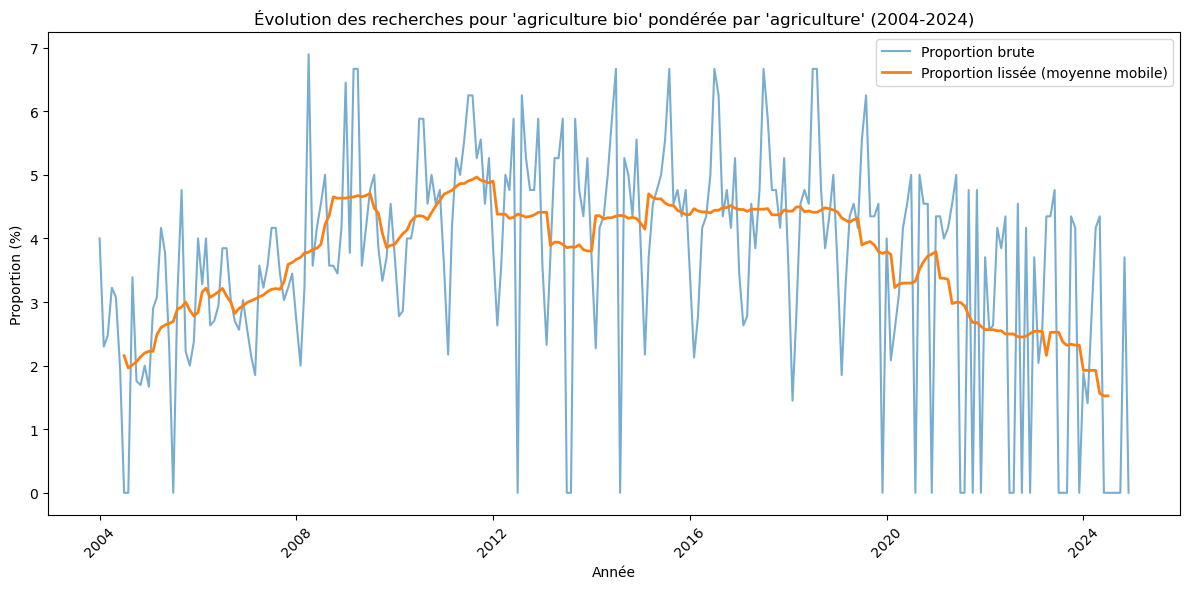

In [ ]:
# Construire la requête pour les mots-clés
try:
    pytrends.build_payload(keywords, geo='FR', timeframe=f'{start_date} {end_date}')
    
    # Récupérer les données d'intérêt au fil du temps
    data = pytrends.interest_over_time()

    # Vérifier que les données contiennent des résultats valides
    if data.empty:
        print("Aucune donnée disponible pour les mots-clés fournis.")
    else:
        # Calculer le ratio (agriculture bio / agriculture) * 100
        data['ratio'] = (data['agriculture bio'] / data['agriculture']) * 100

        # Appliquer un lissage avec une moyenne mobile (fenêtre de 12 mois)
        data['smoothed_ratio'] = data['ratio'].rolling(window=12, center=True).mean()

        # Créer le graphique
        plt.figure(figsize=(12, 6))

        # Tracer le ratio brut
        plt.plot(data.index, data['ratio'], label="Proportion brute", alpha=0.6)

        # Tracer le ratio lissé
        plt.plot(data.index, data['smoothed_ratio'], label="Proportion lissée (moyenne mobile)", linewidth=2)

        # Ajouter les labels et la légende
        plt.title("Évolution des recherches pour 'agriculture bio' pondérée par 'agriculture' (2004-2024)")
        plt.xlabel("Année")
        plt.ylabel("Proportion (%)")
        plt.legend()

        # Afficher le graphique
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        result = data[['Month_Year', 'smoothed_ratio']]

except Exception as e:
    print(f"Erreur lors de la récupération des données : {e}")


In [ ]:
# Créer un objet MinMaxScaler
scaler = MinMaxScaler()

# Appliquer la normalisation Min-Max à la colonne 'smoothed_ratio'
result['normalized_min_max'] = scaler.fit_transform(result[['smoothed_ratio']])

# Sélectionner uniquement les colonnes 'Month_Year' et 'normalized_min_max'
result_normalized = result[['Month_Year', 'normalized_min_max']]

# Sauvegarder dans un fichier CSV
result_normalized.to_csv('data_quantitative.csv', index=False, header=True)

print("Le fichier CSV avec le mois et la valeur normalisée Min-Max a été créé avec succès.")

/opt/conda/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Mois avec des pics détectés dans la courbe lissée :
['2005-10', '2006-03', '2006-07', '2007-08', '2008-10', '2009-04', '2009-07', '2010-07', '2011-09', '2012-01', '2012-07', '2013-08', '2013-10', '2014-08', '2014-11', '2015-03', '2016-02', '2016-11', '2017-08', '2017-12', '2018-06', '2018-10', '2019-06', '2019-09', '2020-01', '2020-05', '2021-01', '2023-10', '2023-12']


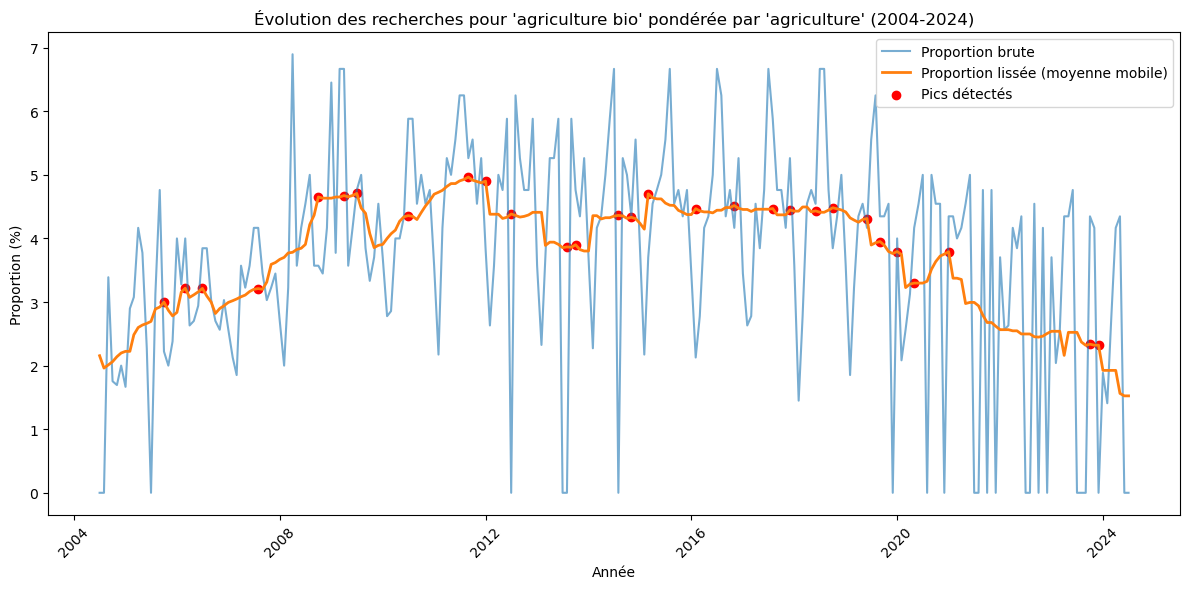

In [ ]:
# Construction du graphique avec les pics
try:
    pytrends.build_payload(keywords, geo='FR', timeframe=f'{start_date} {end_date}')
    
    # Récupérer les données d'intérêt au fil du temps
    data = pytrends.interest_over_time()

    # Vérifier que les données contiennent des résultats valides
    if data.empty:
        print("Aucune donnée disponible pour les mots-clés fournis.")
    else:
        # Calculer le ratio (agriculture bio / agriculture) * 100
        data['ratio'] = (data['agriculture bio'] / data['agriculture']) * 100

        # Appliquer un lissage avec une moyenne mobile (fenêtre de 12 mois)
        data['smoothed_ratio'] = data['ratio'].rolling(window=12, center=True).mean()

        # Identifier les pics locaux (maxima) dans la courbe lissée
        data = data.dropna()  # Supprimer les valeurs NaN après le lissage
        peaks_indices = argrelextrema(data['smoothed_ratio'].values, comparator=lambda x, y: x > y)[0]
        peaks_months = data.iloc[peaks_indices].index.strftime('%Y-%m').tolist()

        print("Mois avec des pics détectés dans la courbe lissée :")
        print(peaks_months)

        # Créer le graphique
        plt.figure(figsize=(12, 6))

        # Tracer le ratio brut
        plt.plot(data.index, data['ratio'], label="Proportion brute", alpha=0.6)

        # Tracer le ratio lissé
        plt.plot(data.index, data['smoothed_ratio'], label="Proportion lissée (moyenne mobile)", linewidth=2)

        # Mettre en évidence les pics détectés
        plt.scatter(data.iloc[peaks_indices].index, data.iloc[peaks_indices]['smoothed_ratio'], color='red', label="Pics détectés")

        # Ajouter les labels et la légende
        plt.title("Évolution des recherches pour 'agriculture bio' pondérée par 'agriculture' (2004-2024)")
        plt.xlabel("Année")
        plt.ylabel("Proportion (%)")
        plt.legend()

        # Afficher le graphique
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Erreur lors de la récupération des données : {e}")


## Analyse initiale pics :  
Nous avons réalisé une courbe montrant tous les pics d'intérêt mensuel pour le ratio *"agriculture biologique"* sur *"agriculture"*. L'objectif était d'identifier des événements ou des mois particuliers pouvant expliquer ces variations. Cependant, aucune explication claire ou récurrente n'a pu être identifiée en analysant ces pics. Cela suggère que ces fluctuations sont probablement aléatoires ou liées à des phénomènes spécifiques difficiles à cerner. D'où notre choix de lisser la courbe.
